# Text Summarization
## —— Based on BART (Bilingual Evaluation Understudy)

在这里，我们将尝试使用BART框架，基于AutoDL云上服务器，使用训练集对模型进行微调，从而尝试实现文本摘要。

本次实验是在参阅了大量技术文档后编写的，并且还在实验过程中发现了一些在网络上编写技术文档的人的代码错误。在这里，我们提供可以运行与复现结果的代码。

Reference github repository: https://github.com/abhimishra91/transformers-tutorials/blob/master/transformers_summarization_wandb.ipynb

### 1. 调取必要模块 

In [1]:
# 基础模块
import numpy as np
import pandas as pd
from rouge import Rouge
import torch
import torch.nn.functional as F
from sklearn.model_selection import KFold
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate import meteor_score
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

# 基于Transformers架构的T5框架
from transformers import BartTokenizer, BartForConditionalGeneration

In [2]:
# 这段代码的目的是在AutoDL云上服务器中开启加速
# 从而更快地获取来自HuggingFace的内容
# 选自AutoDL的帮助文档
# 个人建议在AutoDL的环境下运行，或直接不运行这段代码。否则可能出现错误。

"""
如果在载入模块时连接时间过长，可以启用这段代码
建议在AutoDL的环境下运行，或自行配置合适的环境
否则可能出现错误！
"""
# import subprocess
# import os
# 
# result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
# output = result.stdout
# for line in output.splitlines():
#     if '=' in line:
#         var, value = line.split('=', 1)
#         os.environ[var] = value

In [3]:
# 调用GPU
# 本人租用的服务器采用了具有2块GPU的RTX 4090
from torch import cuda
device = "cuda" if cuda.is_available() else "cpu"

print(device)

cuda


### 2. 自定义数据集
基于train.csv设计的自定义数据集，为后续神经网络的微调做准备。

In [4]:
class MedicalDataset(Dataset):

    def __init__(self, dataframe, tokenizer, source_len, summ_len):
        # tokenizer: 用于分词
        self.tokenizer = tokenizer
        # data: 存储数据
        self.data = dataframe
        # description的内容的长度
        self.source_len = source_len
        # diagnosis的内容的长度
        self.summ_len = summ_len
        # csv文件中description列的内容
        self.description = self.data.description
        # csv文件中diagnosis列的内容
        self.diagnosis = self.data.diagnosis

    # 返回数据的数量
    def __len__(self):
        return len(self.description)
    
    def __getitem__(self, index):
        # 如果文本中有多个连续空格
        # 则合并为一个空格
        diagnosis = str(self.diagnosis[index])
        diagnosis = ' '.join(diagnosis.split())
        description = str(self.description[index])
        description = ' '.join(description.split())
        # batch_encode_plus将文本转为模型可以处理的编码
        source = self.tokenizer.batch_encode_plus([description],
                                                  max_length = self.source_len,     # 指定编码后文本最大长度
                                                  padding = 'max_length',           # 填充使得每个文本长度相同
                                                  return_tensors = 'pt',            # 返回Pytorch的张量
                                                  truncation = True)                # 如果超过最大长度，需要截断
        target = self.tokenizer.batch_encode_plus([diagnosis],
                                                  max_length = self.summ_len,       # 指定编码后文本最大长度
                                                  padding = 'max_length',           # 填充使得每个文本长度相同
                                                  return_tensors = 'pt',            # 返回Pytorch的张量
                                                  truncation = True)                # 如果超过最大长度，需要截断
        
        # Pytorch中的squeeze函数移除大小为1的维度
        # 张量形状更紧凑
        # input_ids返回了编码后的文本的token IDs
        # attention_mask二进制掩码，表明哪些位置是填充，注意力机制不应放在填充位置
        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()

        return {
            'source_ids': source_ids.to(dtype=torch.long),
            'source_mask': source_mask.to(dtype=torch.long),
            'target_ids': target_ids.to(dtype=torch.long)
        }

### 3. 编写训练函数
训练集会经过训练函数，从而达成模型的微调。

In [5]:
loss_array = []

def train(epoch, tokenizer, model, device, loader, optimizer):
    model.train()
    for _, data in enumerate(loader):
        y = data['target_ids'].to(device, dtype = torch.long)
        # 获取 y 的每一行，且不要最后一个标记
        # 用contiguous使张量连续
        y_ids = y[:, :-1].contiguous()
        # detach让labels不用参与梯度计算
        labels = y[:, 1:].clone().detach()
        # 填充位置对应的损失值设为-100
        # -100是Pytorch中的一个特殊值，计算损失时会忽略这些位置
        labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)
        
        outputs = model(input_ids = ids,
                        attention_mask = mask,
                        decoder_input_ids = y_ids,
                        labels = labels)
        loss = outputs[0]
        
        if _%10 == 0:
            loss_array.append(loss.item())
        if _%500 == 0:
            print(f'Epoch: {epoch + 1}, Loss: {loss.item()}')
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

### 4. 编写验证函数

In [6]:
def validate(tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actual = []
    with torch.no_grad():
        for _, data in enumerate(loader):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)
            
            generated_ids = model.generate(input_ids = ids,
                                           attention_mask = mask,
                                           max_length = 200,
                                           # Beam Search的参数数量
                                           num_beams = 2,
                                           # 重复惩罚
                                           repetition_penalty = 2.5,
                                           # 长度惩罚
                                           length_penalty = 1.0,
                                           # 要求在遇到End of Sequence时停止
                                           # 若设置为False，会生成直到最大长度
                                           early_stopping = True)
            preds = [tokenizer.decode(g,
                                      skip_special_tokens = True,
                                      clean_up_tokenization_spaces = True) for g in generated_ids]
            
            target = [tokenizer.decode(t,
                                       skip_special_tokens = True,
                                       clean_up_tokenization_spaces = True) for t in y]
            
            if _%100 == 0:
                print(f"Completed {_}")
                
            predictions.extend(preds)
            actual.extend(target)
        return predictions, actual

### 5. 训练模型

In [7]:
# 设定参数
TRAIN_BATCH_SIZE = 2 # 训练的批次大小
VALID_BATCH_SIZE = 2 # 测试的批次大小
TRAIN_EPOCHS = 3     # 训练的轮次数量
LEARNING_RATE = 1e-4 # 学习率
SEED = 42            # 随机种子
MAX_LEN = 512        # source_len
SUMMARY_LEN = 200    # summ_len

In [8]:
# 设置随机种子
torch.manual_seed(SEED)
np.random.seed(SEED)

# 可复现性
torch.backends.cudnn.deterministic = True

In [9]:
# Tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

In [10]:
# 导入数据
df = pd.read_csv("train.csv")
df = df[['description', 'diagnosis']]
print(df.head())

                                         description  \
0  14 108 28 30 15 13 294 29 20 18 23 21 25 32 16...   
1  22 12 1137 41 17 16 96 17 16 34 48 17 30 40 13...   
2  14 108 333 30 15 13 31 29 20 829 891 21 25 11 ...   
3  22 12 135 269 205 24 267 27 12 376 32 94 109 2...   
4  34 12 48 63 109 28 30 40 13 1038 52 43 23 21 5...   

                                           diagnosis  
0                               22 12 38 41 17 81 10  
1  66 75 80 116 17 81 16 33 81 16 33 24 122 370 1...  
2                        35 48 49 150 167 308 282 10  
3  14 49 123 55 86 57 54 40 138 124 26 105 133 13...  
4  34 12 48 1064 86 57 54 138 10 22 12 38 41 17 8...  


In [11]:
# 定义参数
# num_workers = 0 表示在主进程中加载数据
train_params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}

val_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
}

In [15]:
# 导入数据
df = pd.read_csv("train.csv")
df = df[['description', 'diagnosis']]
print(df.head())

# 创建符合格式预期的数据集
training_set = MedicalDataset(df, tokenizer, MAX_LEN, SUMMARY_LEN)
training_loader = DataLoader(training_set, **train_params)

# 使用预训练的T5-base模型
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
model = model.to(device)

# 定义优化器，使用Adam
optimizer = torch.optim.Adam(params = model.parameters(), lr = LEARNING_RATE)

                                         description  \
0  14 108 28 30 15 13 294 29 20 18 23 21 25 32 16...   
1  22 12 1137 41 17 16 96 17 16 34 48 17 30 40 13...   
2  14 108 333 30 15 13 31 29 20 829 891 21 25 11 ...   
3  22 12 135 269 205 24 267 27 12 376 32 94 109 2...   
4  34 12 48 63 109 28 30 40 13 1038 52 43 23 21 5...   

                                           diagnosis  
0                               22 12 38 41 17 81 10  
1  66 75 80 116 17 81 16 33 81 16 33 24 122 370 1...  
2                        35 48 49 150 167 308 282 10  
3  14 49 123 55 86 57 54 40 138 124 26 105 133 13...  
4  34 12 48 1064 86 57 54 138 10 22 12 38 41 17 8...  


In [16]:
# 正式开始训练
print("开始模型微调")

for epoch in range(TRAIN_EPOCHS):
    train(epoch, tokenizer, model, device, training_loader, optimizer)

开始模型微调
Epoch: 1, Loss: 7.01186990737915
Epoch: 1, Loss: 4.748305797576904
Epoch: 1, Loss: 3.6500799655914307
Epoch: 1, Loss: 2.1577937602996826
Epoch: 1, Loss: 2.0433881282806396
Epoch: 1, Loss: 2.156229257583618
Epoch: 1, Loss: 1.3087271451950073
Epoch: 1, Loss: 1.366681456565857
Epoch: 1, Loss: 3.512167453765869
Epoch: 1, Loss: 1.9891910552978516
Epoch: 1, Loss: 1.9585500955581665
Epoch: 1, Loss: 2.299180269241333
Epoch: 1, Loss: 2.5831809043884277
Epoch: 1, Loss: 2.563215494155884
Epoch: 1, Loss: 1.6537789106369019
Epoch: 1, Loss: 1.3894035816192627
Epoch: 1, Loss: 2.7646074295043945
Epoch: 1, Loss: 2.113461971282959
Epoch: 2, Loss: 2.35563063621521
Epoch: 2, Loss: 2.6693053245544434
Epoch: 2, Loss: 1.6176177263259888
Epoch: 2, Loss: 1.9760687351226807
Epoch: 2, Loss: 1.5883495807647705
Epoch: 2, Loss: 1.0219988822937012
Epoch: 2, Loss: 1.674642562866211
Epoch: 2, Loss: 1.5471633672714233
Epoch: 2, Loss: 2.074522018432617
Epoch: 2, Loss: 2.4399609565734863
Epoch: 2, Loss: 0.76209264

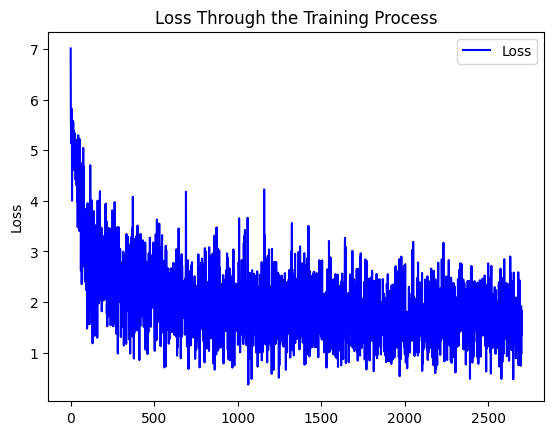

In [17]:
# 绘制损失函数曲线图
import matplotlib.pyplot as plt

# 创建 x 轴的坐标，这里使用列表的索引作为 x 轴坐标
x = list(range(1, len(loss_array) + 1))

plt.plot(x, loss_array, color='b', label='Loss')

plt.title('Loss Through the Training Process')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [18]:
df_test = pd.read_csv("test.csv")
val_dataset = df_test[['description', 'diagnosis']]
print(df_test.head())

val_set = MedicalDataset(val_dataset, tokenizer, MAX_LEN, SUMMARY_LEN)
val_loader = DataLoader(val_set, **val_params)

   index                                        description  \
0      0  185 185 185 185 22 12 116 71 64 694 40 13 146 ...   
1      1  14 281 28 30 15 13 20 18 23 21 25 10 14 32 101...   
2      2  34 12 129 373 27 160 181 75 100 31 29 92 177 1...   
3      3  22 12 48 16 85 63 109 28 16 74 914 64 56 40 13...   
4      4  35 12 163 63 103 63 12 142 13 45 52 139 195 21...   

                                           diagnosis  
0  22 12 74 71 823 56 91 208 73 14 198 209 14 426...  
1           34 12 49 167 57 92 11 117 118 316 441 10  
2  34 12 129 373 27 160 181 77 75 100 308 282 76 ...  
3  14 66 55 86 57 54 10 185 295 14 1236 208 14 19...  
4  227 185 35 12 163 63 16 103 63 14 190 57 76 24...  


In [19]:
print("在测试集上测试")

predictions, actual = validate(tokenizer, model, device, val_loader)
final_df = pd.DataFrame({'Generated Text':predictions, 'Actual Text':actual})
final_df.to_csv('predictions_bart.csv')

print("输出文件已保存")

在测试集上测试
Completed 0
Completed 100
Completed 200
Completed 300
Completed 400
Completed 500
Completed 600
Completed 700
Completed 800
Completed 900
输出文件已保存


In [20]:
df = pd.read_csv("predictions_bart.csv")
rouge1_p = 0
rouge1_r = 0
rouge1_f = 0
rouge2_p = 0
rouge2_r = 0
rouge2_f = 0
rougel_p = 0
rougel_r = 0
rougel_f = 0
bleu_average = 0
meteor_average = 0
rouge = Rouge()
for i in range(2000):
    answer = df["Actual Text"][i]
    summary = df["Generated Text"][i]
    scores = rouge.get_scores(summary, answer)
    rouge1_p += scores[0]["rouge-1"]["p"] / 2000
    rouge1_r += scores[0]["rouge-1"]["r"] / 2000
    rouge1_f += scores[0]["rouge-1"]["f"] / 2000
    rouge2_p += scores[0]["rouge-2"]["p"] / 2000
    rouge2_r += scores[0]["rouge-2"]["r"] / 2000
    rouge2_f += scores[0]["rouge-2"]["f"] / 2000
    rougel_p += scores[0]["rouge-l"]["p"] / 2000
    rougel_r += scores[0]["rouge-l"]["r"] / 2000
    rougel_f += scores[0]["rouge-l"]["f"] / 2000
    answer_nltk = [answer]
    bleu_average += sentence_bleu(answer_nltk, summary) / 2000
    summary_tokens = summary.split()
    answer_nltk_2 = [reference.split() for reference in answer_nltk]
    meteor_average += meteor_score.meteor_score(answer_nltk_2, summary_tokens) / 2000

print("The precision of Rouge 1 is:", rouge1_p)
print("The recall of Rouge 1 is:", rouge1_r)
print("The F1 of Rouge 1 is:", rouge1_f)
print("The precision of Rouge 2 is:", rouge2_p)
print("The recall of Rouge 2 is:", rouge2_r)
print("The F1 of Rouge 2 is:", rouge2_f)
print("The precision of Rouge l is:", rougel_p)
print("The recall of Rouge l is:", rougel_r)
print("The F1 of Rouge l is:", rougel_f)
print("BLEU Score:", bleu_average)
print("METEOR Score:", meteor_average)

/root/miniconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


The precision of Rouge 1 is: 0.6401956596795175
The recall of Rouge 1 is: 0.543213155613839
The F1 of Rouge 1 is: 0.5638466452776829
The precision of Rouge 2 is: 0.44762273095909794
The recall of Rouge 2 is: 0.38038737751066887
The F1 of Rouge 2 is: 0.39279798111789754
The precision of Rouge l is: 0.6087588595722079
The recall of Rouge l is: 0.5174279034447854
The F1 of Rouge l is: 0.5365382938270415
BLEU Score: 0.4648433070353966
METEOR Score: 0.4968411448617106


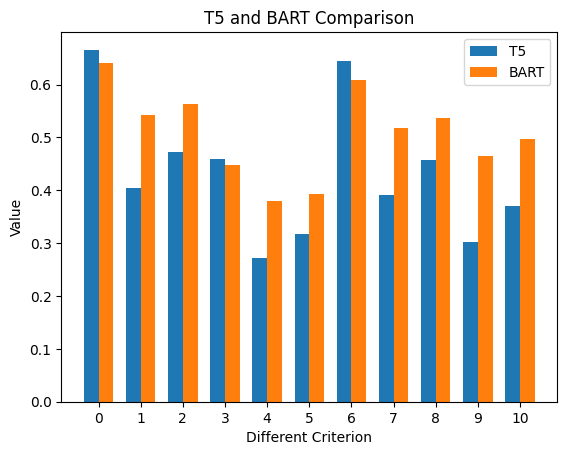

In [2]:
x_values = np.arange(11)
y1_values = [0.666, 0.404, 0.472, 0.460, 0.272, 0.318, 0.645, 0.392, 0.458, 0.302, 0.371]
y2_values = [0.640, 0.543, 0.564, 0.448, 0.380, 0.393, 0.609, 0.517, 0.537, 0.465, 0.497]

bar_width = 0.35

plt.bar(x_values, y1_values, width=bar_width, label='T5')
plt.bar(x_values + bar_width, y2_values, width=bar_width, label='BART')

plt.xlabel('Different Criterion')
plt.ylabel('Value')
plt.title('T5 and BART Comparison')

plt.xticks(x_values + bar_width / 2, x_values)

plt.legend()
plt.show()